Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Mask Labels

* Mask specified % of labels as unknown labels
* Type 1 Mask: each class has labeled and unlabeled records
* Type 2 Mask: only 1 class has some labeled records

In [1]:
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

from umap import UMAP

import warnings
warnings.filterwarnings('ignore')

In [2]:
label_col = 'deposit'
masked_label = 'masked_deposit'

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/deposit.pkl')
print(raw_df.shape)
print(raw_df[label_col].value_counts())

raw_df.head()

(11162, 17)
0    5873
1    5289
Name: deposit, dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


### Type 1 Mask

* Each class has labeled and unlabeled records

In [24]:
def mask_labels(df, label_col, masked_label, mask_rate=0.95):
    df['keep_label'] = True 
    df.loc[df.sample(frac=mask_rate, random_state=10).index, 'keep_label'] = False
    df[masked_label] = df.apply(lambda r: r[label_col] if r['keep_label']==True else -1, axis=1)
    
    return df

In [25]:
raw_df = mask_labels(raw_df, label_col, masked_label, mask_rate=0.95)
print(raw_df[masked_label].value_counts()*100/raw_df.shape[0])
print()
print(raw_df[raw_df[masked_label]==-1][label_col].value_counts()*100/raw_df[raw_df[masked_label]==-1].shape[0])
raw_df.head()

-1    95.000896
 0     2.723526
 1     2.275578
Name: masked_deposit, dtype: float64

0    52.517918
1    47.482082
Name: deposit, dtype: float64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,keep_label,masked_deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,False,-1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1,False,-1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,False,-1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1,False,-1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1,False,-1


In [26]:
all_y_df = raw_df[[label_col, 'keep_label', masked_label]]
y = raw_df[masked_label]
X = raw_df.drop(all_y_df.columns, axis=1)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)
all_y_train = all_y_df.iloc[y_train.index]
all_y_test = all_y_df.iloc[y_test.index]
print(X_train.shape, y_train.shape, all_y_train.shape, X_test.shape, y_test.shape, all_y_test.shape)
print(y_train.value_counts()*100/y_train.shape)
print(y_test.value_counts()*100/y_test.shape)
print()

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
all_y_train.reset_index(inplace=True, drop=True)
all_y_test.reset_index(inplace=True, drop=True)

(11162, 16) (11162,)
(8371, 16) (8371,) (8371, 3) (2791, 16) (2791,) (2791, 3)
-1    95.006570
 0     2.723689
 1     2.269741
Name: masked_deposit, dtype: float64
-1    94.983877
 0     2.723038
 1     2.293085
Name: masked_deposit, dtype: float64



In [27]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
encoder = TargetEncoder(cols=cat_features)
encoded_X_train = encoder.fit_transform(X_train, y_train)
encoded_X_test = encoder.transform(X_test)

encoded_X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,89,-0.918782,-0.923674,-0.928191,-0.926587,553,-0.918753,-0.92698,-0.917785,19,-0.951754,2027,5,-1,0,-0.929878
1,43,-0.930435,-0.923674,-0.928191,-0.926587,-183,-0.918753,-0.92698,-0.925207,24,-0.916300,65,1,-1,0,-0.929878
2,40,-0.927300,-0.923674,-0.928191,-0.926587,1293,-0.918753,-0.92698,-0.925207,16,-0.891667,1702,3,105,2,-0.931762
3,45,-0.927300,-0.923674,-0.929418,-0.926587,-312,-0.936887,-0.92698,-0.925207,16,-0.916300,268,1,-1,0,-0.929878
4,32,-0.934608,-0.930969,-0.929418,-0.926587,131,-0.936887,-0.92698,-0.925207,21,-0.950617,322,1,189,1,-0.931762


In [28]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(encoded_X_train)
scaled_X_test = scaler.transform(encoded_X_test)

scaled_X_train

array([[0.92207792, 0.51516652, 1.        , ..., 0.        , 0.        ,
        0.0375623 ],
       [0.32467532, 0.3747614 , 1.        , ..., 0.        , 0.        ,
        0.0375623 ],
       [0.28571429, 0.41253528, 1.        , ..., 0.12397661, 0.03448276,
        0.        ],
       ...,
       [0.36363636, 0.3747614 , 1.        , ..., 0.        , 0.        ,
        0.0375623 ],
       [0.27272727, 0.41253528, 0.        , ..., 0.        , 0.        ,
        0.0375623 ],
       [0.33766234, 0.41678573, 1.        , ..., 0.        , 0.        ,
        0.0375623 ]])

In [ ]:
embed = UMAP(n_neighbors=200,
               n_components=2,
               metric='euclidean',
               n_epochs=1000,
               learning_rate=0.1,
               init='spectral',
               min_dist=0.1,
               spread=1.0,
               low_memory=True,
               set_op_mix_ratio=1.0,
               random_state=10,
               transform_seed=10,
               verbose=False,
               unique=False
              )

umap_X_train = embed.fit_transform(scaled_X_train)
umap_df_train = pd.DataFrame(umap_X_train, columns=['col1', 'col2'])
umap_train = pd.concat([umap_df_train, all_y_train], axis=1)

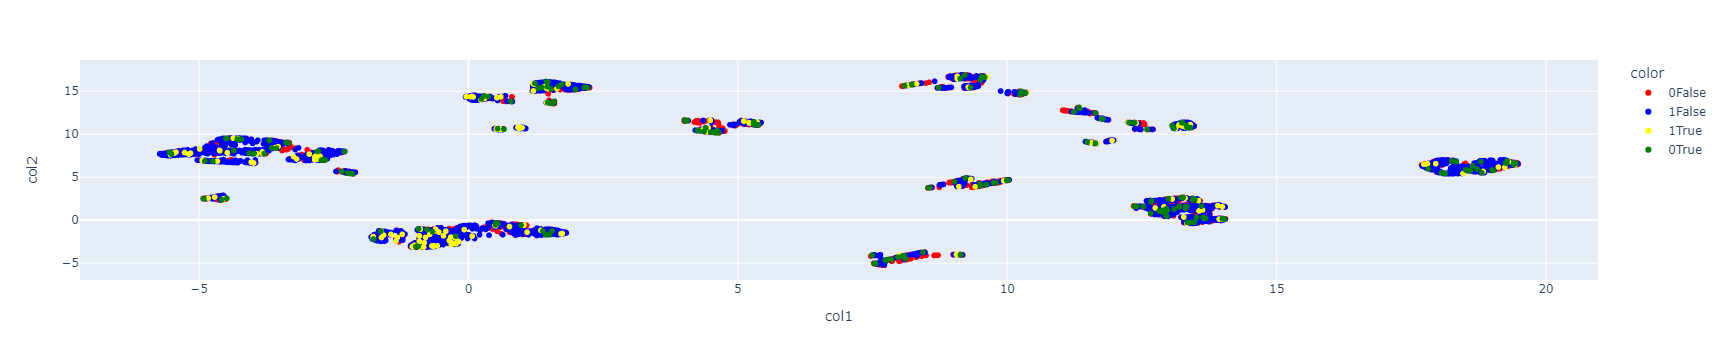

In [43]:
fig = px.scatter(umap_train, x='col1', y='col2', opacity=1, color=umap_train[label_col].astype(str) + umap_train['keep_label'].astype(str),
                 color_discrete_sequence=['red', 'blue', 'yellow', 'green', 0.5]
                )
fig.show()

In [44]:
umap_X_test = embed.fit_transform(scaled_X_test)
umap_df_test = pd.DataFrame(umap_X_test, columns=['col1', 'col2'])
umap_test = pd.concat([umap_df_test, all_y_test], axis=1)

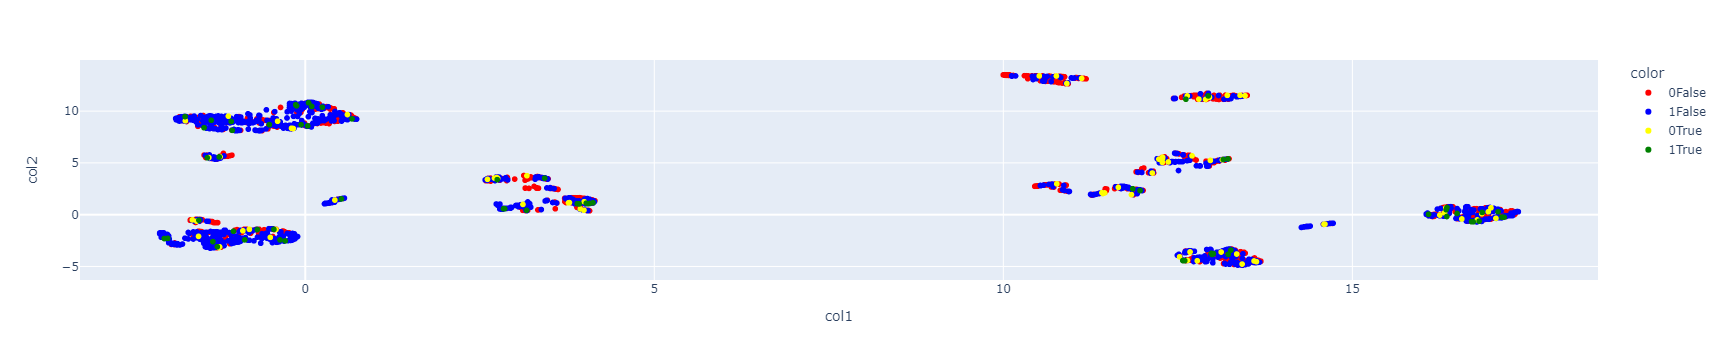

In [45]:
fig = px.scatter(umap_test, x='col1', y='col2', opacity=1, color=umap_test[label_col].astype(str) + umap_test['keep_label'].astype(str),
                 color_discrete_sequence=['red', 'blue', 'yellow', 'green', 0.5]
                )
fig.show()

### Type 2 Mask

* Only 1 class has some labeled records

In [3]:
def mask_labels_1class_labeled(df, label_col, masked_label, partially_labeled_class=1, mask_rate=0.95):
    df['keep_label'] = False 
    df.loc[df[df[label_col]==partially_labeled_class].sample(frac=1-mask_rate, random_state=10).index, 'keep_label'] = True
    df[masked_label] = df.apply(lambda r: r[label_col] if r['keep_label']==True else -1, axis=1)
    
    return df

In [5]:
raw_df = mask_labels_1class_labeled(raw_df, label_col, masked_label, partially_labeled_class=1, mask_rate=0.95)
print(raw_df[masked_label].value_counts()*100/raw_df.shape[0])
print()
print(raw_df[raw_df[masked_label]==-1][label_col].value_counts()*100/raw_df[raw_df[masked_label]==-1].shape[0])
raw_df.head()

-1    97.634832
 1     2.365168
Name: masked_deposit, dtype: float64

0    53.890622
1    46.109378
Name: deposit, dtype: float64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,keep_label,masked_deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,False,-1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1,False,-1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,False,-1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1,False,-1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1,True,1
